In [0]:
#IMPORT DATA FROM GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#Dependencies
!pip uninstall keras
!pip install keras==2.0.3

Uninstalling Keras-2.2.4:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/Keras-2.2.4.dist-info/*
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.2.4
     |████████████████████████████████| 204kB 6.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/a6/fb/de/faea9e49d563a35f198c6dede7f9260074b5beb8f9bffaaaa1
Successfully built keras
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.3 which is incompatible.


In [0]:
#UNZIP THE DATA
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Internship - sample damage labelling 600 images.zip", 'r') #read from zip location
zip_ref.extractall("/content/files") #upzip at new location
zip_ref.close()

In [0]:
#!rm -r "/content/files/Internship/train_images"

In [0]:
#Get images information group by 'Dent' and 'Scratch_or_spot' classes beacuse other classes have less data
from xml.dom import minidom
import pandas as pd
import os

df_cols = ["filename", "class", "xmin", "ymin", "xmax", "ymax"]
out_df = pd.DataFrame(columns = df_cols)


for i in (os.listdir("/content/files/Internship/annot_chem4")):
  anno_name="/content/files/Internship/annot_chem4/"+i
  parsedXML = minidom.parse(anno_name)
  try:
    if(parsedXML.getElementsByTagName('name')[0].firstChild.data == 'Dent' or parsedXML.getElementsByTagName('name')[0].firstChild.data == 'Scratch_or_spot'):
      try:
        image_name = parsedXML.getElementsByTagName("filename")[0].firstChild.data
        class_name = parsedXML.getElementsByTagName("name")[0].firstChild.data
 
        xmin = parsedXML.getElementsByTagName("xmin")[0].firstChild.data 
        ymin = parsedXML.getElementsByTagName("ymin")[0].firstChild.data
        xmax = parsedXML.getElementsByTagName("xmax")[0].firstChild.data
        ymax = parsedXML.getElementsByTagName("ymax")[0].firstChild.data
      except IndexError:
        xmin=0
        ymin=0
        xmax=0
        ymax=0
      out_df = out_df.append(pd.Series([image_name,class_name,xmin,ymin,xmax,ymax], index = df_cols), ignore_index=True)  
  except:
      pass
  

In [5]:
out_df.shape

(246, 6)

In [0]:
out_df_train

In [6]:
out_df['class'].value_counts()

Scratch_or_spot    136
Dent               110
Name: class, dtype: int64

In [0]:
out_df_train=out_df[0:196].copy()
out_df_test=out_df[196:246].copy()

In [0]:
#Divide data into train and test
import os
import random
import shutil
import numpy as np


os.makedirs("/content/files/Internship/train_images")
os.makedirs("/content/files/Internship/test_images")

for i in out_df['filename']:
  temp=0
  for j in out_df_test['filename']:
    if (j==i):
      shutil.copy("/content/files/Internship/images_chem4/"+str(i),"/content/files/Internship/test_images")
      temp=1
  if(temp==0):
    shutil.copy("/content/files/Internship/images_chem4/"+str(i),"/content/files/Internship/train_images")



In [55]:
!pwd

/content/keras-frcnn


In [0]:
#Save train images information into 'train.csv'
out_df_train.to_csv("train.csv", index=False, encoding='utf-8')

In [9]:
#Clone FCRNN repository
!git clone https://github.com/kbardool/keras-frcnn.git

Cloning into 'keras-frcnn'...
remote: Enumerating objects: 589, done.
remote: Total 589 (delta 0), reused 0 (delta 0), pack-reused 589
Receiving objects: 100% (589/589), 178.49 KiB | 830.00 KiB/s, done.
Resolving deltas: 100% (396/396), done.


In [0]:
#Copy to keras-frcnn folder

In [10]:
shutil.move("/content/train.csv","/content/keras-frcnn")

'/content/keras-frcnn/train.csv'

In [11]:
shutil.move("/content/files/Internship/train_images","/content/keras-frcnn")

'/content/keras-frcnn/train_images'

In [12]:
shutil.move("/content/files/Internship/test_images","/content/keras-frcnn")

'/content/keras-frcnn/test_images'

In [14]:
%cd "/content/keras-frcnn"

/content/keras-frcnn


In [0]:
#Pretrained weight
shutil.move("/content/drive/My Drive/model_frcnn.hdf5","/content/keras-frcnn")

In [0]:
#Make a config file "annotate.txt" for training
train = pd.read_csv("train.csv")
data = pd.DataFrame()
data["format"] = train["filename"]

# add xmin, ymin, xmax, ymax and class as per the format required
for i in range(data.shape[0]):
    data["format"][i] = "train_images/" + str(data["format"][i]) + "," + str(train["xmin"][i]) + "," + str(train["ymin"][i]) + "," + str(train["xmax"][i]) + "," + str(train["ymax"][i]) + "," + train["class"][i]

data.to_csv("annotate.txt", header=None, index=None, sep=" ")

In [20]:
train.shape

(196, 6)

In [0]:
#Change itterations of epochs
!sed -i -- 's/epoch_length = 1000/epoch_length = 50/g' train_frcnn.py

In [22]:
#TRAIN
!python train_frcnn.py -o simple -p annotate.txt --num_epochs 10 --hf True --vf True --input_weight_path model_frcnn.hdf5

Using TensorFlow backend.
Parsing annotation files
Training images per class:
{'Dent': 90, 'Scratch_or_spot': 106, 'bg': 0}
Num classes (including bg) = 3
Config has been written to config.pickle, and can be loaded when testing to ensure correct results
Num train samples 164
Num val samples 32
W0710 20:08:59.031496 140414486972288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:47: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 20:08:59.032483 140414486972288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:351: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 20:08:59.038101 140414486972288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3176: The name tf.random_uniform is deprecated. Please use tf.random.uniform

In [0]:
#Change in test file
!sed -i -- 's/cv2.imshow('img', img)/#imshow('img', img)/g' test_frcnn.py
!sed -i -- 's/cv2.waitKey(0)/#cv2.waitKey(0)/g' test_frcnn.py
!sed -i -- 's/# cv2.imwrite('./results_imgs/{}.png'.format(idx),img)/cv2.imwrite('./results_imgs/{}.png'.format(idx),img)/g' test_frcnn.py

In [0]:
#Create result directory 
import os
os.makedirs("/content/keras-frcnn/results")

In [0]:
#!rm -r "/content/keras-frcnn/results"

In [25]:
#TEST
!python test_frcnn.py -p test_images

Using TensorFlow backend.
{0: 'Scratch_or_spot', 1: 'Dent', 2: 'bg'}
W0710 20:21:29.274873 140629155207040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:47: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 20:21:29.275865 140629155207040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:351: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 20:21:29.281586 140629155207040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3176: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 20:21:29.320688 140629155207040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3043: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_poo

In [0]:
files.download("/content/keras-frcnn/results")

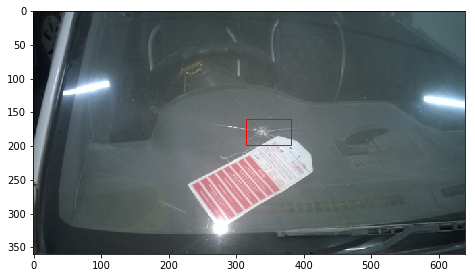

In [0]:
#Check classes in main image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('/content/files/Internship/images_chem4/akhand_b43_0.jpg')
plt.imshow(image)

train = pd.read_csv("train.csv")

# iterating over the image for different objects
for _,row in train[train['filename'] == "akhand_b43_0.jpg"].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
   
    
    # assign different color to different classes of objects
    if row['class'] == 'Dent':
        edgecolor = 'r'
        ax.annotate('Dent', xy=(xmax-40,ymin+20))
    elif row['class'] == 'Scratch_or_spot 	':
        edgecolor = 'b'
        ax.annotate('Scratch_or_spot', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = 'r', facecolor = 'none')
    
    ax.add_patch(rect)